# Prediction of COVID-19 Around the World

| Student | __Angela Amador__ |
| ------ | ----- |
| TMU Student Number | __500259095__ |
| Supervisor | __Tamer Abdou, PhD__  |

I aim to demonstrate how Machine Learning (ML) models were able to predict the spread of COVID-19 around the world.

First, I will explore the dataset to get insights and better understand patterns, detect error and outliers, and find relationships between variables.

## Preparation

The dataset is taken from Our World in Data website, officially collected by Our World in Data team: https://covid.ourworldindata.org/data/owid-covid-data.csv.

The dataset, provides COVID-19 information collected by [Our World in Data](https://www.kaggle.com/datasets/caesarmario/our-world-in-data-covid19-dataset) and made available by the Kaggle community https://www.kaggle.com/datasets/caesarmario/our-world-in-data-covid19-dataset/download?datasetVersionNumber=418. This dataset is updated daily.

In [169]:
import warnings

# Use jupyter_black to automatically format the code
import black
import jupyter_black
import matplotlib.pyplot as plt
import numpy as np

# Import libraries
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Markdown, display
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, VarianceThreshold, chi2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVC
from ydata_profiling import ProfileReport


jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="INFO",
    target_version=black.TargetVersion.PY310,
)

# Use pycodestyle to enforce coding standards.
%load_ext pycodestyle_magic
%pycodestyle_off

warnings.filterwarnings("ignore")
InteractiveShell.ast_node_interactivity = "all"

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


Helper function to generate a markdown table with details of a dataframe.

In [170]:
def df_details(label, df):
    """ Generate a markdown table with details of a dataframe """
    display(
        Markdown(
            rf"""
| {label} | |
| --- | ---: |
| Number of observations | {df.shape[0]} |
| Number of attributes | {df.shape[1]} |
| Size | {df.size} |
"""
        )
    )

### Load file and explore data

For the purpose of this study I am analyzing the data with information up to Oct 7th, 2023.

In [171]:
# Load file
raw_data = pd.read_csv("archive.zip", sep=",")

# Explore data
raw_data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


Due to large number iso_code and location, I need to make a decision of droping information outside Noth America.

The original dataset had 346,567 observations and 67 attributes. After applying One Hot Encoding, it became to 552 attributes. 

In [172]:
df_details("\nOriginal Dataset", raw_data)

raw_data = raw_data[raw_data["continent"].isin(["North America"])]
# raw_data.drop(raw_data[raw_data.location in ["Canada", "United States", "Mexico"]].index)

df_details("\nAfter removing data before vaccinate was available " +
           "around the world (Jan 1st, 2021)", raw_data)


| 
Original Dataset | |
| --- | ---: |
| Number of observations | 346567 |
| Number of attributes | 67 |
| Size | 23219989 |



| 
After removing data before vaccinate was available around the world (Jan 1st, 2021) | |
| --- | ---: |
| Number of observations | 56215 |
| Number of attributes | 67 |
| Size | 3766405 |


### Check the data type and metadata of the attributes

In [173]:
# look at meta information about data, such as data types and null values
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56215 entries, 9597 to 328906
Data columns (total 67 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   iso_code                                    56215 non-null  object 
 1   continent                                   56215 non-null  object 
 2   location                                    56215 non-null  object 
 3   date                                        56215 non-null  object 
 4   total_cases                                 53290 non-null  float64
 5   new_cases                                   56062 non-null  float64
 6   new_cases_smoothed                          55852 non-null  float64
 7   total_deaths                                48572 non-null  float64
 8   new_deaths                                  56062 non-null  float64
 9   new_deaths_smoothed                         55857 non-null  float64
 10  total_cases

Look at meta information about numeric data, we can also see if there any
extreme values.

In [174]:
raw_data.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,5.329000e+04,5.606200e+04,55852.000000,4.857200e+04,56062.000000,55857.000000,53290.000000,56062.000000,55852.000000,48572.000000,...,16454.000000,17825.000000,31535.000000,54844.000000,31535.000000,5.621500e+04,1.697000e+03,1697.000000,1697.000000,1697.000000
mean,1.678567e+06,2.220623e+03,2228.968943,2.841419e+04,28.647480,28.734093,114259.003401,169.315114,169.941166,965.665755,...,22.308223,77.542464,2.316462,77.210638,0.755958,1.464554e+07,1.337685e+05,10.214673,13.031827,1536.920768
std,1.067253e+07,2.233718e+04,20530.179250,1.377650e+05,203.221894,187.557893,140654.821916,1188.239018,548.357237,835.599102,...,10.426533,18.699787,1.388615,3.962192,0.088248,5.507602e+07,3.004476e+05,12.492085,29.576679,1687.862378
min,1.000000e+00,0.000000e+00,0.000000,1.000000e+00,0.000000,0.000000,0.003000,0.000000,0.000000,0.003000,...,9.900000,22.863000,0.600000,64.000000,0.510000,4.413000e+03,-1.364700e+04,-27.640000,-95.920000,-2752.924800
25%,2.185500e+03,0.000000e+00,0.000000,3.000000e+01,0.000000,0.000000,5366.823500,0.000000,0.000000,226.603000,...,17.400000,76.665000,1.300000,74.470000,0.716000,5.649400e+04,6.640000e+01,2.920000,-1.810000,107.882980
50%,1.219700e+04,0.000000e+00,6.286000,1.880000e+02,0.000000,0.000000,55256.183500,0.000000,21.616000,760.779000,...,20.400000,85.198000,2.300000,77.020000,0.778000,1.911730e+05,1.958200e+03,8.790000,6.970000,947.998540
75%,1.349345e+05,4.300000e+01,97.143000,3.124000e+03,0.000000,1.000000,171124.076000,47.822000,122.803250,1594.159500,...,23.100000,88.469000,3.000000,80.220000,0.810000,5.180836e+06,4.226531e+04,15.160000,18.440000,2942.505900
max,1.034368e+08,1.265520e+06,809735.286000,1.127152e+06,5061.000000,3407.857000,626793.139000,98045.879000,14443.500000,3331.912000,...,53.300000,90.650000,5.800000,83.920000,0.929000,3.382899e+08,1.276845e+06,57.140000,343.020000,5470.329000


### Remove observations with NaN Total Cases which is our predictor variable

In [175]:
display(Markdown(f"""
The dataset has a total of {raw_data["total_cases"].isna().sum()}
observations with empty total_cases.
"""))


The dataset has a total of 2925
observations with empty total_cases.


In [176]:
raw_data = raw_data.drop(
    raw_data[raw_data["total_cases"].isna()].index
    )

df_details("After removing observations with NaN " +
           "Total Cases", raw_data)


| After removing observations with NaN Total Cases | |
| --- | ---: |
| Number of observations | 53290 |
| Number of attributes | 67 |
| Size | 3570430 |


### Remove data pre-dating COVID vaccine availability

Multiple vaccines became available on the second semester of 2020. By December most countries have approved vaccines for their own country. 

As vaccinations changed the behaviour of the pandemic I will remove data before Jan 1st, 2021 to consider data only after vaccines became availability.

In [177]:
raw_data = raw_data.drop(raw_data[raw_data.date < "2021-01-01"].index)

df_details("\nAfter removing data before vaccinate was available " +
           "around the world (Jan 1st, 2021)", raw_data)


| 
After removing data before vaccinate was available around the world (Jan 1st, 2021) | |
| --- | ---: |
| Number of observations | 41287 |
| Number of attributes | 67 |
| Size | 2766229 |


Reindex the dataset

In [178]:
raw_data = raw_data.reset_index(drop = True)
raw_data.head()
raw_data.tail()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AIA,North America,Anguilla,2021-01-01,13.0,0.0,0.286,NaN,0.0,0.0,...,NaN,NaN,NaN,81.88,NaN,15877.0,NaN,NaN,NaN,NaN
1,AIA,North America,Anguilla,2021-01-02,14.0,1.0,0.429,NaN,0.0,0.0,...,NaN,NaN,NaN,81.88,NaN,15877.0,NaN,NaN,NaN,NaN
2,AIA,North America,Anguilla,2021-01-03,15.0,1.0,0.429,NaN,0.0,0.0,...,NaN,NaN,NaN,81.88,NaN,15877.0,NaN,NaN,NaN,NaN
3,AIA,North America,Anguilla,2021-01-04,15.0,0.0,0.429,NaN,0.0,0.0,...,NaN,NaN,NaN,81.88,NaN,15877.0,NaN,NaN,NaN,NaN
4,AIA,North America,Anguilla,2021-01-05,15.0,0.0,0.286,NaN,0.0,0.0,...,NaN,NaN,NaN,81.88,NaN,15877.0,NaN,NaN,NaN,NaN


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
41282,VIR,North America,United States Virgin Islands,2023-09-30,25389.0,0.0,0.0,132.0,0.0,0.0,...,NaN,NaN,NaN,80.58,NaN,99479.0,NaN,NaN,NaN,NaN
41283,VIR,North America,United States Virgin Islands,2023-10-01,25389.0,0.0,0.0,132.0,0.0,0.0,...,NaN,NaN,NaN,80.58,NaN,99479.0,NaN,NaN,NaN,NaN
41284,VIR,North America,United States Virgin Islands,2023-10-02,25389.0,0.0,0.0,132.0,0.0,0.0,...,NaN,NaN,NaN,80.58,NaN,99479.0,NaN,NaN,NaN,NaN
41285,VIR,North America,United States Virgin Islands,2023-10-03,25389.0,0.0,0.0,132.0,0.0,0.0,...,NaN,NaN,NaN,80.58,NaN,99479.0,NaN,NaN,NaN,NaN
41286,VIR,North America,United States Virgin Islands,2023-10-04,25389.0,0.0,0.0,132.0,0.0,0.0,...,NaN,NaN,NaN,80.58,NaN,99479.0,NaN,NaN,NaN,NaN


Change 'total_cases' datatype to integer

In [179]:
raw_data['total_cases'] = raw_data['total_cases'].astype(int)
raw_data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41287 entries, 0 to 41286
Data columns (total 67 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   iso_code                                    41287 non-null  object 
 1   continent                                   41287 non-null  object 
 2   location                                    41287 non-null  object 
 3   date                                        41287 non-null  object 
 4   total_cases                                 41287 non-null  int64  
 5   new_cases                                   41146 non-null  float64
 6   new_cases_smoothed                          41146 non-null  float64
 7   total_deaths                                39780 non-null  float64
 8   new_deaths                                  41143 non-null  float64
 9   new_deaths_smoothed                         41143 non-null  float64
 10  total_case

### One Hot Encoding in Machine Learning

Machine Learning models do not work with categorical data and to fit this data into the machine learning model it needs to be converted into numerical data. One technique is to use One Hot Encoding technique. One hot encoding is a technique that we use to represent categorical variables as numerical values in a machine learning model.

We have four catgorical variables in the dataset: iso_code, continent, location and tests_units.

In [180]:
print("Describe categorical variables")
print("\niso_code:")
raw_data['iso_code'].describe(include='all')
print("\ncontinent:")
raw_data['continent'].describe(include='all')
print("\nlocation:")
raw_data['location'].describe(include='all')
print("\ntests_units:")
raw_data['tests_units'].describe(include='all')

Describe categorical variables

iso_code:


count     41287
unique       41
top         AIA
freq       1007
Name: iso_code, dtype: object


continent:


count             41287
unique                1
top       North America
freq              41287
Name: continent, dtype: object


location:


count        41287
unique          41
top       Anguilla
freq          1007
Name: location, dtype: object


tests_units:


count                9029
unique                  3
top       tests performed
freq                 5551
Name: tests_units, dtype: object

#### Create New DataFrame
Now, for using categorical variables we will create a new dataframe of selected categorical columns.

In [181]:
categorical_cols = ['iso_code', 'continent', 'location', 'tests_units']
categorical_df = raw_data[categorical_cols]
categorical_df.head()

,iso_code,continent,location,tests_units
0,AIA,North America,Anguilla,NaN
1,AIA,North America,Anguilla,NaN
2,AIA,North America,Anguilla,NaN
3,AIA,North America,Anguilla,NaN
4,AIA,North America,Anguilla,NaN


#### Finding Unique Values

For finding unique values we will use pandas unique() function.

In [182]:
# unique values in each columns
for x in categorical_df.columns:
    print(x, ':', len(categorical_df[x].unique()))

iso_code : 41
continent : 1
location : 41
tests_units : 4


Examine How many columns we will obatain after one hot encoding these variables

In [183]:
pd.get_dummies(categorical_df, drop_first=False).shape

(41287, 86)

Apply One Hot Encoding to all 4 categorical variables: 'iso_code', 'continent', 'location' and 'tests_units'

In [184]:
# One-hot encoding
encoder = OneHotEncoder(sparse_output=False)

raw_data_cols = raw_data.shape[1]

# One-hot encoding 'iso_code' column
origin_encoded = encoder.fit_transform(raw_data[['iso_code']])
df_encoded = pd.concat([
    raw_data,
    pd.DataFrame(origin_encoded, columns=encoder.categories_[0])
    ], axis=1)

# df_encoded.head()

if df_encoded.columns.is_unique is False:
    # print('\nDuplicate columns after iso_code encoding\n')
    duplicate_cols = df_encoded.columns[df_encoded.columns.duplicated()]
    df_encoded.drop(columns=duplicate_cols, inplace=True)

df_encoded_iso_code = df_encoded.shape[1]

df_details("\nAfter One hot encoding: iso_code", df_encoded)

# One-hot encoding 'continent' column
origin_encoded = encoder.fit_transform(raw_data[['continent']])

df_encoded = pd.concat([
    df_encoded,
    pd.DataFrame(origin_encoded, columns=encoder.categories_[0])
    ], axis=1)

# Continent created a column NaN at the end, eliminating this column
df_encoded = df_encoded.iloc[:, :-1]

if df_encoded.columns.is_unique is False:
    # print('\nDuplicate columns after continent encoding\n')
    duplicate_cols = df_encoded.columns[df_encoded.columns.duplicated()]
    df_encoded.drop(columns=duplicate_cols, inplace=True)

df_encoded_continent = df_encoded.shape[1]

df_details("\nAfter One hot encoding: continent", df_encoded)

# One-hot encoding 'location' column
origin_encoded = encoder.fit_transform(df_encoded[['location']])
df_encoded = pd.concat([
    df_encoded,
    pd.DataFrame(origin_encoded, columns=encoder.categories_[0])
    ], axis=1)

# location created a column NaN at the end, eliminating this column
df_encoded = df_encoded.iloc[:, :-1]

if df_encoded.columns.is_unique is False:
    # print('\nDuplicate columns after location encoding\n')
    duplicate_cols = df_encoded.columns[df_encoded.columns.duplicated()]
    df_encoded.drop(columns=duplicate_cols, inplace=True)

df_encoded_location = df_encoded.shape[1]

df_details("\nAfter One hot encoding: location", df_encoded)

# One-hot encoding 'tests_units' column
origin_encoded = encoder.fit_transform(df_encoded[['tests_units']])
df_encoded = pd.concat([
    df_encoded,
    pd.DataFrame(origin_encoded, columns=encoder.categories_[0])
    ], axis=1)

# set the max columns to none
# pd.set_option('display.max_columns', None)

# tests_units created a column NaN at the end, eliminating this column
df_encoded = df_encoded.iloc[:, :-1]

if df_encoded.columns.is_unique is False:
    # print('\nDuplicate columns after tests_units encoding\n')
    duplicate_cols = df_encoded.columns[df_encoded.columns.duplicated()]
    df_encoded.drop(columns=duplicate_cols, inplace=True)

df_encoded_tests_units = df_encoded.shape[1]
df_details("\nAfter One hot encoding: tests_units", df_encoded)
# df_encoded.columns
# df_encoded.columns[-10:]
# df_encoded.info()
# list(df_encoded.columns)
# list(pd.get_dummies(categorical_df, drop_first=True).columns)
df_encoded.head()


| 
After One hot encoding: iso_code | |
| --- | ---: |
| Number of observations | 41287 |
| Number of attributes | 108 |
| Size | 4458996 |



| 
After One hot encoding: continent | |
| --- | ---: |
| Number of observations | 41287 |
| Number of attributes | 108 |
| Size | 4458996 |



| 
After One hot encoding: location | |
| --- | ---: |
| Number of observations | 41287 |
| Number of attributes | 148 |
| Size | 6110476 |



| 
After One hot encoding: tests_units | |
| --- | ---: |
| Number of observations | 41287 |
| Number of attributes | 151 |
| Size | 6234337 |


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,Saint Martin (French part),Saint Pierre and Miquelon,Saint Vincent and the Grenadines,Sint Maarten (Dutch part),Trinidad and Tobago,Turks and Caicos Islands,United States,people tested,samples tested,tests performed
0,AIA,North America,Anguilla,2021-01-01,13,0.0,0.286,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AIA,North America,Anguilla,2021-01-02,14,1.0,0.429,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AIA,North America,Anguilla,2021-01-03,15,1.0,0.429,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AIA,North America,Anguilla,2021-01-04,15,0.0,0.429,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AIA,North America,Anguilla,2021-01-05,15,0.0,0.286,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [185]:
display(Markdown(f"""
We got a total of {df_encoded.shape[1]} columns.:
- {raw_data.shape[1]} from original dataset
- After adding {len(raw_data['iso_code'].unique())}
unique values from iso_code, we got a total of {df_encoded_iso_code}
columns
- After adding {len(raw_data['continent'].unique())-1}
unique values from continent, we got a total of {df_encoded_continent}
columns
- After adding {len(raw_data['location'].unique())-1}
unique values from location, we got a total of {df_encoded_location}
 columns
- After adding {len(raw_data['tests_units'].unique())-1}
unique values from tests_units, we got a total of {df_encoded_tests_units}
columns
"""))


We got a total of 151 columns.:
- 67 from original dataset
- After adding 41
unique values from iso_code, we got a total of 108
columns
- After adding 0
unique values from continent, we got a total of 108
columns
- After adding 40
unique values from location, we got a total of 148
 columns
- After adding 3
unique values from tests_units, we got a total of 151
columns


In [186]:
# Droping the categorical variables
# and leaving the encoded columns

df_encoded = df_encoded.drop(columns=categorical_cols)

df_details("\nAfter eliminating categorial attributes and " +
           "leaving encoded columns from One Hot Encoding", df_encoded)

df_encoded.head()


| 
After eliminating categorial attributes and leaving encoded columns from One Hot Encoding | |
| --- | ---: |
| Number of observations | 41287 |
| Number of attributes | 147 |
| Size | 6069189 |


,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,...,Saint Martin (French part),Saint Pierre and Miquelon,Saint Vincent and the Grenadines,Sint Maarten (Dutch part),Trinidad and Tobago,Turks and Caicos Islands,United States,people tested,samples tested,tests performed
0,2021-01-01,13,0.0,0.286,NaN,0.0,0.0,818.794,0.000,17.995,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-01-02,14,1.0,0.429,NaN,0.0,0.0,881.779,62.984,26.993,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-01-03,15,1.0,0.429,NaN,0.0,0.0,944.763,62.984,26.993,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-01-04,15,0.0,0.429,NaN,0.0,0.0,944.763,0.000,26.993,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-01-05,15,0.0,0.286,NaN,0.0,0.0,944.763,0.000,17.995,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Encode the Categorical Variable Date

In [187]:
# encode the Categorical Variable Date
label_encoder = LabelEncoder()
df_encoded.iloc[:, 0] = label_encoder.fit_transform(
    df_encoded.iloc[:, 0]).astype('int32')

df_encoded.head()

,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,...,Saint Martin (French part),Saint Pierre and Miquelon,Saint Vincent and the Grenadines,Sint Maarten (Dutch part),Trinidad and Tobago,Turks and Caicos Islands,United States,people tested,samples tested,tests performed
0,0,13,0.0,0.286,NaN,0.0,0.0,818.794,0.000,17.995,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,14,1.0,0.429,NaN,0.0,0.0,881.779,62.984,26.993,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,15,1.0,0.429,NaN,0.0,0.0,944.763,62.984,26.993,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,15,0.0,0.429,NaN,0.0,0.0,944.763,0.000,26.993,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,15,0.0,0.286,NaN,0.0,0.0,944.763,0.000,17.995,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Splitting

One of the first decisions to make is how to utilize the existing data. One common technique is to split the data into two groups typically referred to as the Training and Testing sets. The Training set is used to develop
models and feature sets; it is the substrate for estimating parameters, comparing models, and all of the other activities required to reach a final model. The Testing set is used only at the conclusion of these activities for estimating a final, unbiased assessment of the model’s performance. It is critical that the Testing set is not used prior to this point. Looking at the Testing set results would bias the outcomes since the Testing data will have become part of the model development process. Reference: Feature Engineering and Selection A Practical Approach for Predictive Models.

Because we have a date in the dataset, we will use it to create the training dataset and the testing dataset. Training dataset is going to have information for 2021 and 2022 (date encoded <= 729). And Testing dataset will have information for 2023 (date encoded > 729).

In [188]:
# Training dataset is going to have information for 2021 and 2022.
# And Testing dataset will have information for 2023.
split_date = 729 # '2022-12-31'
df_training = df_encoded.loc[df_encoded['date'] <= split_date]
df_test = df_encoded.loc[df_encoded['date'] > split_date]

df_details("Training data set", df_training)
df_details("Testing data set", df_test)


| Training data set | |
| --- | ---: |
| Number of observations | 29930 |
| Number of attributes | 147 |
| Size | 4399710 |



| Testing data set | |
| --- | ---: |
| Number of observations | 11357 |
| Number of attributes | 147 |
| Size | 1669479 |


## Data Cleaning

Data cleaning will take place only on the training dataset

### Identify Columns That Contain a Single Value

The dataset doesn't have columns with a single value.

In [189]:
# get number of unique values for each column
counts = df_training.nunique()

# record columns to delete
to_del = [i for i, v in enumerate(counts) if v == 1]

cols_to_del = df_training.columns[to_del]

# drop useless columns
df_training.drop(cols_to_del, axis=1, inplace=True)
df_details("Training data set after removing columns " +
           "with a single value", df_training)


| Training data set after removing columns with a single value | |
| --- | ---: |
| Number of observations | 29930 |
| Number of attributes | 147 |
| Size | 4399710 |


### Remove data columns with too many NaN values

We can calculate the ratio of missing values using a simple formula. The formula is the number of missing values in each column divided by the total number of observations. Generally, we can drop variables having a missing-value ratio of more than 60% or 70%. For my purpose I am going to use a threashold of 60% missing values and remove those attributes.

In [190]:
# Defining threashold of 60% missing values
threashold_NaN = 0.60


# Explore data
def describe_nan(df):
    "Produce a summary count of nan counts in dataframe"
    return pd.DataFrame(
        [
            (i, df[df[i].isna()].shape[0], df[df[i].isna()].shape[0] / df.shape[0])
            for i in df.columns
        ],
        columns=["column", "nan_counts", "nan_rate"],
    )


pd.options.display.max_rows = None

# icu=raw_data.icu_patients.value_counts(dropna=False)
# display ("NaN entries for the icu_patients column:", icu[icu.index.isnull()])

print("Attributes with more than 60 percentage of missing values:")

describe_nan(df_training).sort_values(by="nan_rate", ascending=False).query(
    "nan_rate >= %s" % threashold_NaN
)

# ((raw_data.isnull() | raw_data.isna()).sum() * 100 / raw_data.index.size).round(2)

Attributes with more than 60 percentage of missing values:


,column,nan_counts,nan_rate
19,weekly_icu_admissions_per_million,29930,1.000000
18,weekly_icu_admissions,29930,1.000000
20,weekly_hosp_admissions,29200,0.975610
21,weekly_hosp_admissions_per_million,29200,0.975610
62,excess_mortality_cumulative_per_million,28958,0.967524
61,excess_mortality,28958,0.967524
60,excess_mortality_cumulative,28958,0.967524
59,excess_mortality_cumulative_absolute,28958,0.967524
14,icu_patients,28470,0.951220
17,hosp_patients_per_million,28470,0.951220


In [191]:
drop_columns_NaN = (
    describe_nan(df_training)
    .sort_values(by="nan_rate", ascending=False)
    .query("nan_rate >= %s" % threashold_NaN)[["column"]]
)
drop_columns_NaN = drop_columns_NaN["column"].to_list()

# Removing data columns with too many missing values
# drop_columns_NaN
df_training_NaN = df_training.drop(drop_columns_NaN, axis=1, inplace=False)

df_details("After removing columns with more than 60 " +
           " percentage of missing values", df_training_NaN)
# df_training_NaN.info()


| After removing columns with more than 60  percentage of missing values | |
| --- | ---: |
| Number of observations | 29930 |
| Number of attributes | 114 |
| Size | 3412020 |


### Feature Selection - Correlation and P-value
https://www.kaggle.com/code/bbloggsbott/feature-selection-correlation-and-p-value

#### How does correlation help in feature selection?
Features with high correlation are more linearly dependent and hence have almost the same effect on the dependent variable. So, when two features have high correlation, we can drop one of the two features.

#### What is p-value?¶
P-value or probability value or asymptotic significance is a probability value for a given statistical model that, if the null hyothesis is true, a set of statistical observations more commonly known as the statistical summary is greater than or equal in magnitude to the observed results.

#### How does p-value help in feature selection?
Removal of different features from the dataset will have different effects on the p-value for the dataset. We can remove different features and measure the p-value in each case. These measured p-values can be used to decide whether to keep a feature or not.

In [192]:
# The numpy.random.seed() makes the random numbers
# predictable and is used for reproducibility
df_training_corr = df_training_NaN

np.random.seed(123)

# df_training_NaN.dtypes

# # encode the Categorical Variable Date
# label_encoder = LabelEncoder()
# df_training_corr.iloc[:, 0] = label_encoder.fit_transform(
#     df_training_corr.iloc[:, 0]).astype('int32')

# df_training_corr.head()

Generating the correlation matrix

In [193]:
corr = df_training_corr.corr()
corr.head()

,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,...,Saint Martin (French part),Saint Pierre and Miquelon,Saint Vincent and the Grenadines,Sint Maarten (Dutch part),Trinidad and Tobago,Turks and Caicos Islands,United States,people tested,samples tested,tests performed
date,1.000000,0.075055,-0.007057,-0.007886,0.040794,-0.074515,-0.081206,0.622872,0.018266,0.044908,...,1.216326e-16,-1.776837e-17,-4.563543e-16,-1.286655e-16,-3.214374e-16,-2.715483e-16,-8.378302e-16,-0.131158,-0.082481,-0.145962
total_cases,0.075055,1.000000,0.526372,0.572273,0.951694,0.520347,0.561351,0.110178,-0.000475,-0.000431,...,-2.725989e-02,-2.734334e-02,-2.727390e-02,-2.726108e-02,-2.589063e-02,-2.729721e-02,9.101481e-01,-0.021216,-0.029618,0.149069
new_cases,-0.007057,0.526372,1.000000,0.923110,0.541748,0.704104,0.640406,0.040010,0.042471,0.066662,...,-1.780407e-02,-1.786369e-02,-1.780358e-02,-1.781658e-02,-1.653381e-02,-1.784654e-02,5.868923e-01,-0.007380,-0.018744,0.158676
new_cases_smoothed,-0.007886,0.572273,0.923110,1.000000,0.585715,0.680679,0.713324,0.044235,0.032189,0.072308,...,-1.922878e-02,-1.929308e-02,-1.922859e-02,-1.924205e-02,-1.786157e-02,-1.927440e-02,6.340116e-01,-0.008058,-0.020254,0.171392
total_deaths,0.040794,0.951694,0.541748,0.585715,1.000000,0.592508,0.639795,0.056726,-0.007615,-0.016817,...,-3.580785e-02,-2.407601e-02,-3.536463e-02,-3.577290e-02,-3.301114e-02,-3.581728e-02,9.105434e-01,0.074303,-0.040533,0.154363


Generating the correlation heatmap

<Axes: >

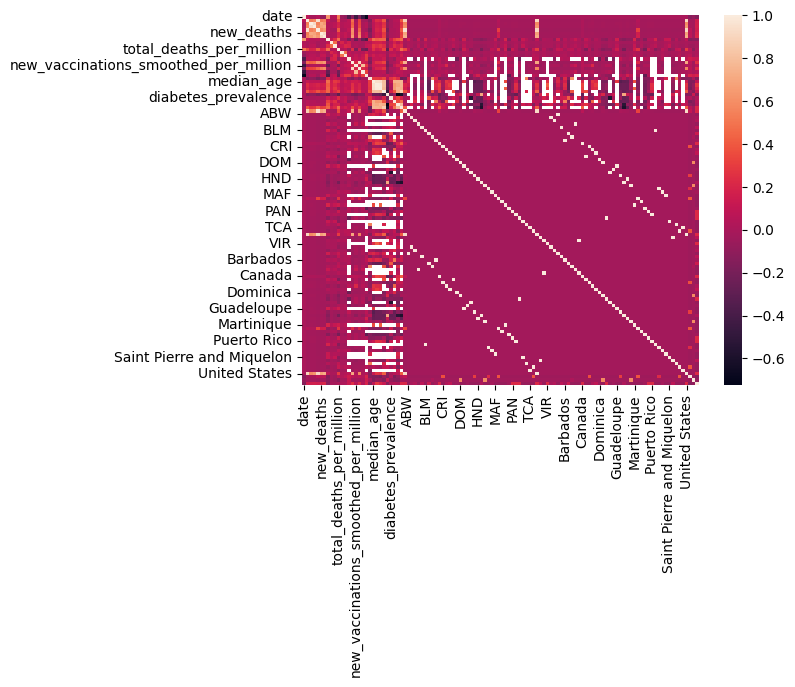

In [194]:
sns.heatmap(corr)

Compare the correlation between features and remove one of two features that have a correlation higher than 0.9

In [195]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i, j] >= 0.9:
            if columns[j]:
                columns[j] = False

selected_columns = df_training_corr.columns[columns]
selected_columns.shape

(66,)

In [196]:
display(Markdown(f"""
A total of {selected_columns.shape[0]} columns were selected.

{selected_columns}
"""))


A total of 66 columns were selected.

Index(['date', 'total_cases', 'new_cases', 'new_deaths',
       'total_cases_per_million', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'new_deaths_smoothed_per_million',
       'reproduction_rate', 'new_vaccinations_smoothed',
       'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed_per_hundred', 'stringency_index',
       'population_density', 'median_age', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'ABW', 'AIA', 'ATG', 'BES', 'BHS', 'BLM',
       'BLZ', 'BMU', 'BRB', 'CAN', 'CRI', 'CUB', 'CUW', 'CYM', 'DMA', 'DOM',
       'GLP', 'GRD', 'GRL', 'GTM', 'HND', 'HTI', 'JAM', 'KNA', 'LCA', 'MAF',
       'MEX', 'MSR', 'MTQ', 'NIC', 'PAN', 'PRI', 'SLV', 'SPM', 'SXM', 'TCA',
       'TTO', 'VCT', 'VGB', 'VIR', 'people tested', 'samples tested',
       'tests performed'],
      dtype='object')


In [197]:
# The dataset has only those columns with correlation less than 0.9
df_training_corr = df_training_corr[selected_columns]

df_details("After removing columns with correlation" +
           " greater than 0.9", df_training_corr)


| After removing columns with correlation greater than 0.9 | |
| --- | ---: |
| Number of observations | 29930 |
| Number of attributes | 66 |
| Size | 1975380 |


In [198]:
df_training_corr.head()

,date,total_cases,new_cases,new_deaths,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,...,SPM,SXM,TCA,TTO,VCT,VGB,VIR,people tested,samples tested,tests performed
0,0,13,0.0,0.0,818.794,0.000,17.995,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,14,1.0,0.0,881.779,62.984,26.993,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,15,1.0,0.0,944.763,62.984,26.993,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,15,0.0,0.0,944.763,0.000,26.993,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,15,0.0,0.0,944.763,0.000,17.995,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Selecting columns based on p-value

Next select the columns based on how they affect the p-value. Remove the column total_cases because it is the column we are trying to predict

In [199]:
# Removing the total_cases column
selected_columns = selected_columns.drop('total_cases')
selected_columns

Index(['date', 'new_cases', 'new_deaths', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate',
       'new_vaccinations_smoothed', 'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed_per_hundred', 'stringency_index',
       'population_density', 'median_age', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'ABW', 'AIA', 'ATG', 'BES', 'BHS', 'BLM',
       'BLZ', 'BMU', 'BRB', 'CAN', 'CRI', 'CUB', 'CUW', 'CYM', 'DMA', 'DOM',
       'GLP', 'GRD', 'GRL', 'GTM', 'HND', 'HTI', 'JAM', 'KNA', 'LCA', 'MAF',
       'MEX', 'MSR', 'MTQ', 'NIC', 'PAN', 'PRI', 'SLV', 'SPM', 'SXM', 'TCA',
       'TTO', 'VCT', 'VGB', 'VIR', 'people tested', 'samples tested',
       'tests performed'],
      dtype='ob

#### Backward Elimination

In [200]:
# Take care of missing values encoded as NaN natively by replacing with the mean

for c in df_training_corr.columns:
    df_training_corr[c] = df_training_corr[c].fillna(df_training_corr[c].mean())

In [201]:
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    # x=np.array(x, dtype=float)
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
    return x, columns, regressor_OLS.summary()

In [202]:
# df_training_corr.head()
# col = 'total_cases'
# df_training_corr.loc[:, df_training_corr.columns != col].head()
# df_training_corr.loc[:, df_training_corr.columns == col].head()

In [203]:
SL = 0.05

col = 'total_cases'

data_modeled, selected_columns, summary = backwardElimination(
    df_training_corr.loc[:, df_training_corr.columns != col].values,
    df_training_corr.loc[:, df_training_corr.columns == col].values,
    SL,
    selected_columns)

summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     6617.
Date:                Sun, 12 Nov 2023   Prob (F-statistic):               0.00
Time:                        22:26:17   Log-Likelihood:            -4.8788e+05
No. Observations:               29930   AIC:                         9.759e+05
Df Residuals:                   29877   BIC:                         9.763e+05
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -615.5883    165.487     -3.720      0.000    -939.951    -291.226
x2            26.5924      0.855     31.091      0.000      24.916      28.269
x3         -8646.8438    124.562    -69.418      0.000   -8890.991   -8402.696
x4             1.6608      0.273      6.092      0.000       1.126       2.195
x5           741.1969     46.343     15.994      0.000     650.362     832.032
x6           -18.3707      0.137   -134.458      0.000     -18.639     -18.103
x7           207.3182     10.817     19.166      0.000     186.116     228.520
x8          -1.24e+06   1.81e+05     -6.863      0.000   -1.59e+06   -8.86e+05
x9         -1.131e+04   1509.582     -7.493      0.000   -1.43e+04   -8352.854
x10        -5.157e+04    134.602   -383.100      0.000   -5.18e+04   -5.13e+04
x11        -7.704e+05   5385.684   -143.046      0.000   -7.81e+05    -7.6e+05
x12         2118.4835      5.140    412.130      0.000    2108.408    2128.559
x13         8.557e+04    396.138    216.011      0.000    8.48e+04    8.63e+04
x14         4.833e+05   8251.376     58.575      0.000    4.67e+05       5e+05
x15        -9.215e+04   2.05e+04     -4.485      0.000   -1.32e+05   -5.19e+04
x16        -4.047e+05   3027.638   -133.659      0.000   -4.11e+05   -3.99e+05
x17         1.425e+07   5.35e+04    266.106      0.000    1.41e+07    1.44e+07
x18         -1.76e+07   1.08e+05   -162.457      0.000   -1.78e+07   -1.74e+07
x19        -4.875e+06   1.08e+05    -45.107      0.000   -5.09e+06   -4.66e+06
x20        -1.107e+07   1.04e+05   -106.491      0.000   -1.13e+07   -1.09e+07
x21        -6.511e+06   1.13e+05    -57.775      0.000   -6.73e+06   -6.29e+06
x22        -3.814e+07   1.35e+05   -282.497      0.000   -3.84e+07   -3.79e+07
x23        -6.105e+06   1.22e+05    -50.083      0.000   -6.34e+06   -5.87e+06
x24         4.904e+05   9.56e+04      5.128      0.000    3.03e+05    6.78e+05
x25        -9.987e+06   8.37e+04   -119.244      0.000   -1.02e+07   -9.82e+06
x26          2.87e+07   1.07e+05    268.547      0.000    2.85e+07    2.89e+07
x27        -4.759e+07   1.62e+05   -294.062      0.000   -4.79e+07   -4.73e+07
x28         2.044e+06   1.16e+05     17.577      0.000    1.82e+06    2.27e+06
x29        -4.434e+06   9.63e+04    -46.063      0.000   -4.62e+06   -4.25e+06
x30          3.99e+06   1.02e+05     38.944      0.000    3.79e+06    4.19e+06
x31        -6.637e+07   2.05e+05   -323.137      0.000   -6.68e+07    -6.6e+07
x32         5.784e+06   1.02e+05     56.689      0.000    5.58e+06    5.98e+06
x33        -4.985e+06   1.51e+05    -32.977      0.000   -5.28e+06   -4.69e+06
x34         2.283e+06   1.06e+05     21.542      0.000    2.08e+06    2.49e+06
x35         2.483e+06   1.02e+05     24.303      0.000    2.28e+06    2.68e+06
x36        -1.949e+07   1.01e+05   -192.236      0.000   -1.97e+07   -1.93e+07
x3

Moving the results to a new dataframe

In [204]:
result = pd.DataFrame()
result['total_cases'] = df_training_corr.loc[
    :, df_training_corr.columns == col]

# result.head()
# result.tail()

result = result.reset_index(drop = True)

# result.head()
# result.tail()

Creating a dataframe with the columns selected using the p-value and correlation

In [205]:
df_training_corr_p_value = pd.DataFrame(
    data = data_modeled,
    columns = selected_columns)

# Also need a dataset that combine both predictive column 'total_cases; and selected columns
df_corr_p_value = pd.concat([
    df_training_corr_p_value,
    result
    ], axis=1)

df_details("After creating a dataframe with the " +
           " columns selected using the p-value" +
           " and correlation", df_corr_p_value)

# df_corr_p_value.head()
# df_training_corr.head()
# result.head()
# df_training_corr_p_value.head()


| After creating a dataframe with the  columns selected using the p-value and correlation | |
| --- | ---: |
| Number of observations | 29930 |
| Number of attributes | 61 |
| Size | 1825730 |


##### Visualizing the selected features

Plotting the data to visualize their distribution

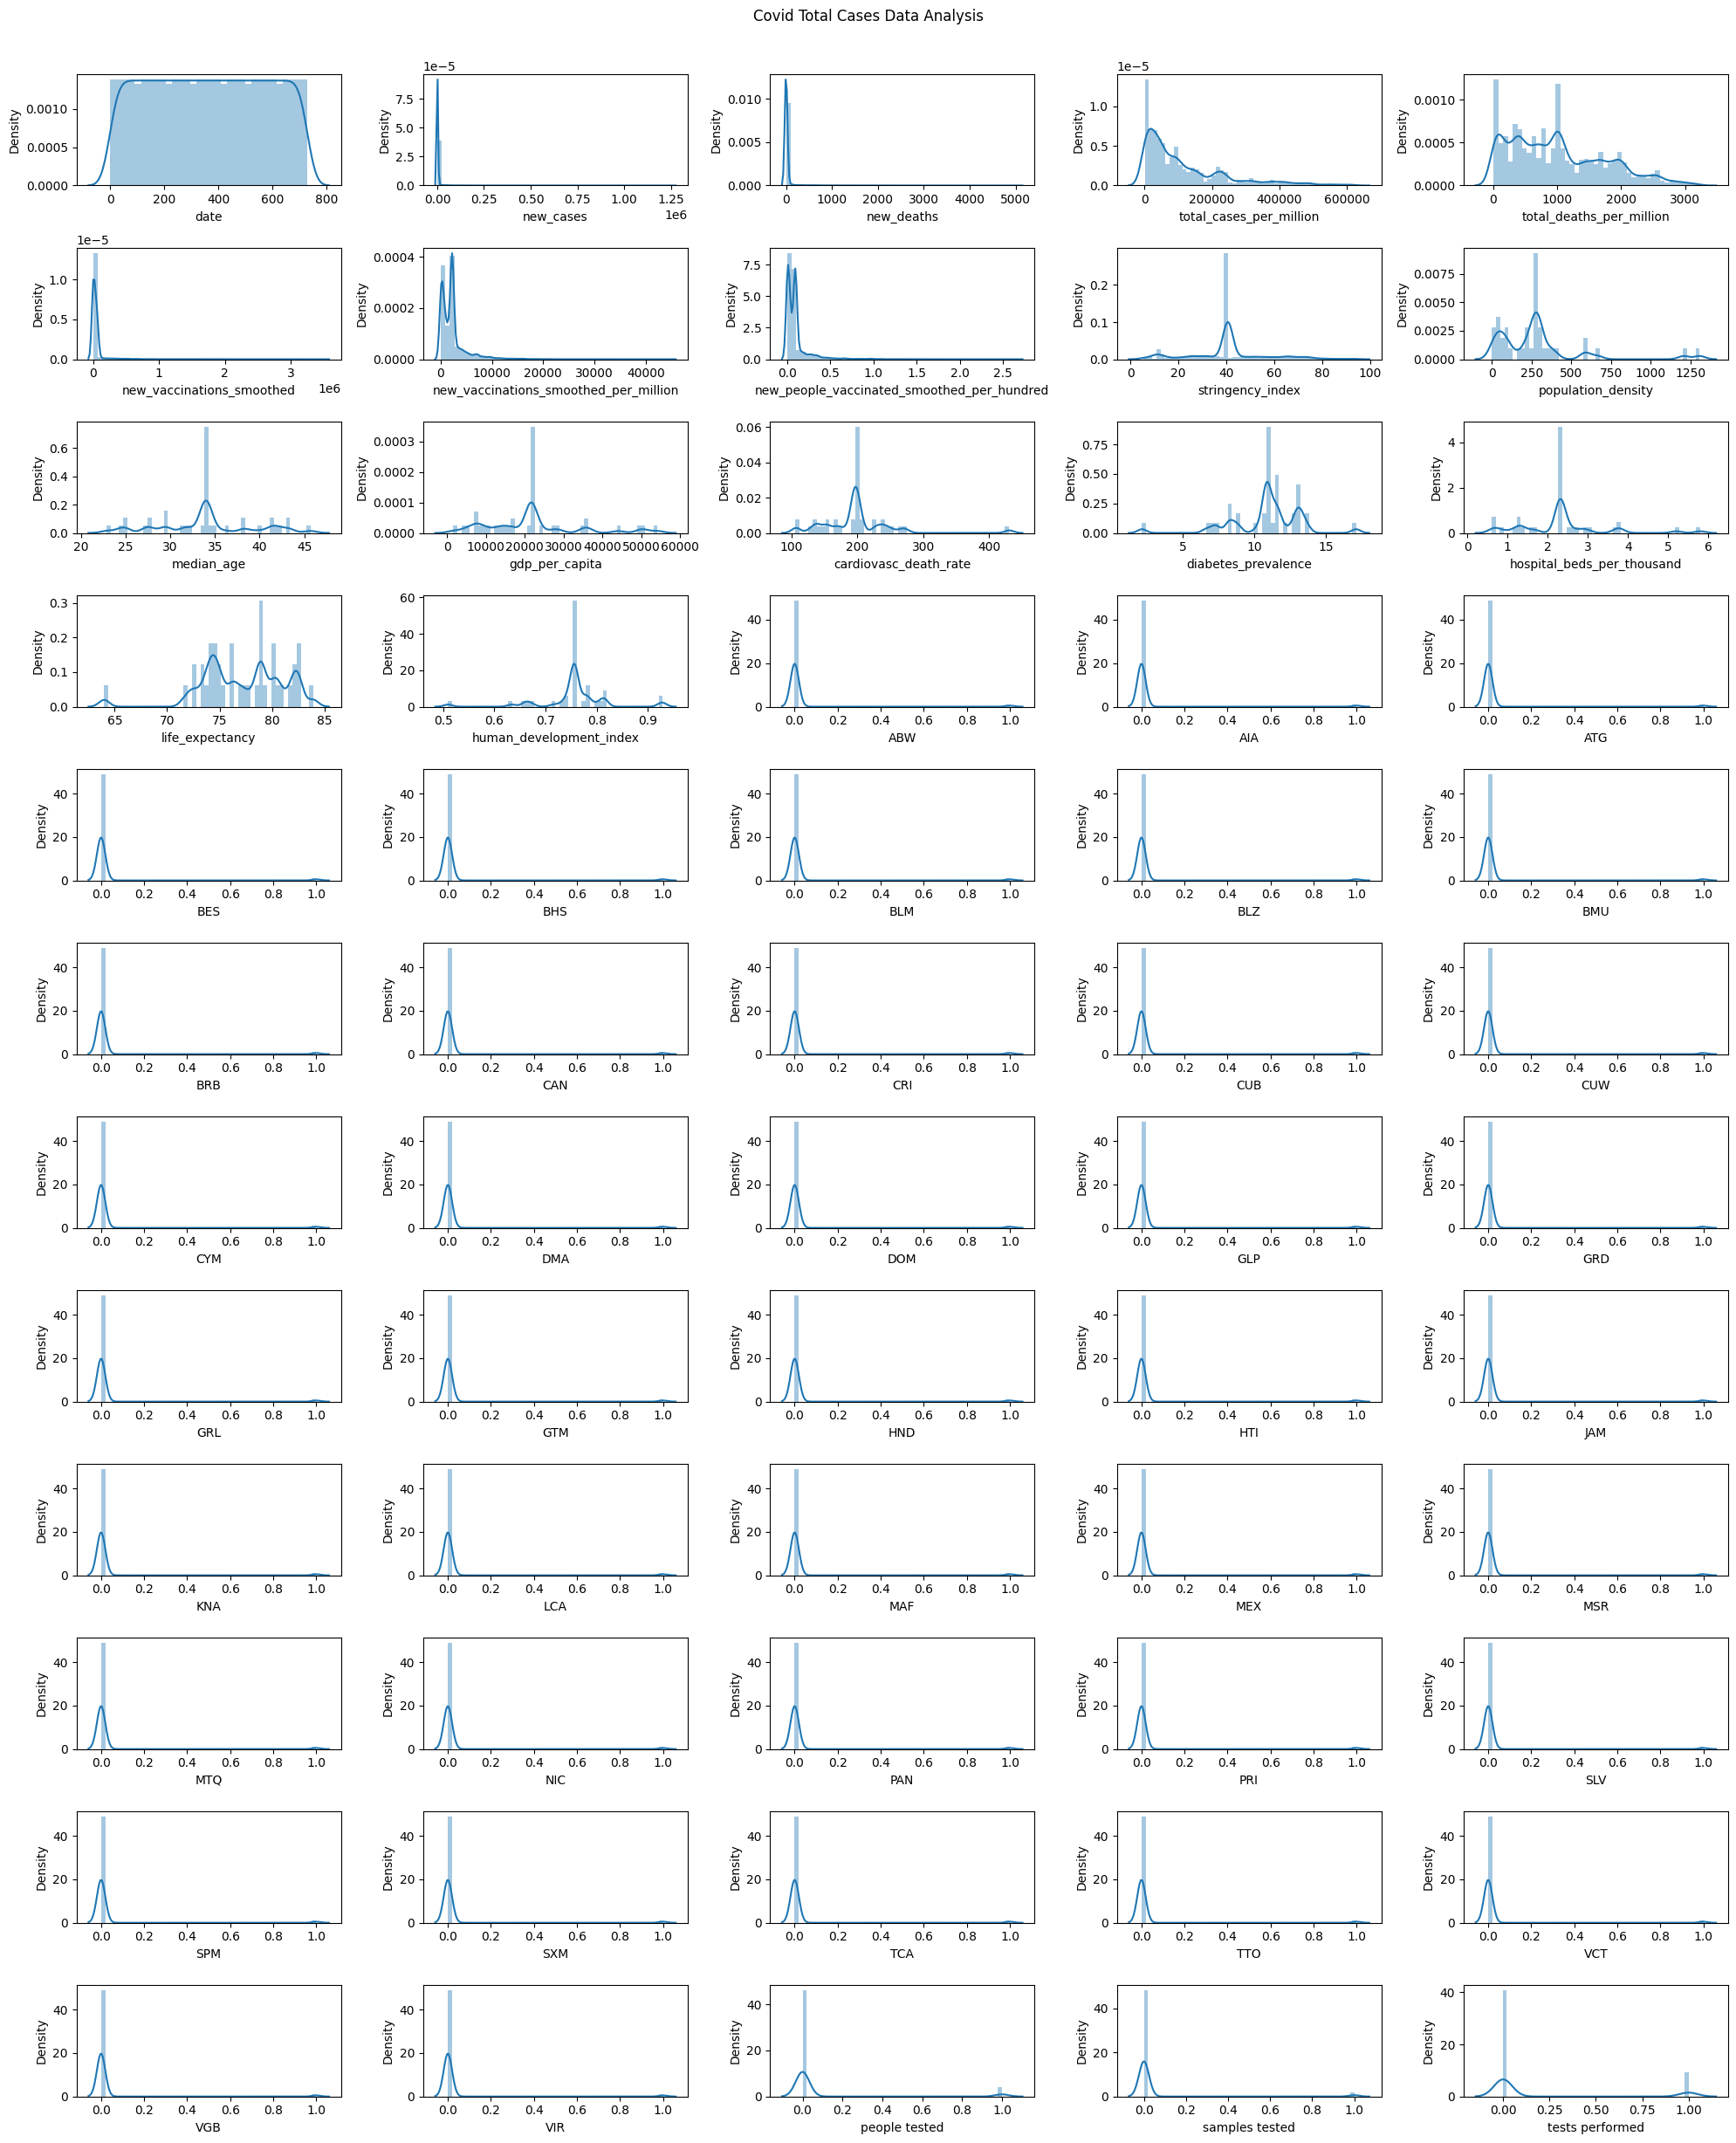

In [206]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in df_training_corr_p_value.columns:
    plt.subplot(12, 5, j+1)
    j += 1
    sns.distplot(df_training_corr_p_value[i])
    # plt.legend(loc='best',fontsize=10)
fig.suptitle('Covid Total Cases Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.show();

In [207]:
df_corr_p_value.head()
df_corr_p_value.tail()

,date,new_cases,new_deaths,total_cases_per_million,total_deaths_per_million,new_vaccinations_smoothed,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed_per_hundred,stringency_index,population_density,...,SXM,TCA,TTO,VCT,VGB,VIR,people tested,samples tested,tests performed,total_cases
0,0.0,0.0,0.0,818.794,1006.815929,52765.571221,2269.027813,0.096096,40.733844,279.976353,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13
1,1.0,1.0,0.0,881.779,1006.815929,52765.571221,2269.027813,0.096096,40.733844,279.976353,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14
2,2.0,1.0,0.0,944.763,1006.815929,52765.571221,2269.027813,0.096096,40.733844,279.976353,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
3,3.0,0.0,0.0,944.763,1006.815929,52765.571221,2269.027813,0.096096,40.733844,279.976353,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
4,4.0,0.0,0.0,944.763,1006.815929,52765.571221,2269.027813,0.096096,40.733844,279.976353,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15


,date,new_cases,new_deaths,total_cases_per_million,total_deaths_per_million,new_vaccinations_smoothed,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed_per_hundred,stringency_index,population_density,...,SXM,TCA,TTO,VCT,VGB,VIR,people tested,samples tested,tests performed,total_cases
29925,725.0,0.0,0.0,238583.018,1276.651,52765.571221,2269.027813,0.096096,40.733844,306.48,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23734
29926,726.0,0.0,0.0,238583.018,1276.651,52765.571221,2269.027813,0.096096,40.733844,306.48,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23734
29927,727.0,30.0,0.0,238884.589,1276.651,52765.571221,2269.027813,0.096096,40.733844,306.48,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23764
29928,728.0,0.0,0.0,238884.589,1276.651,52765.571221,2269.027813,0.096096,40.733844,306.48,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23764
29929,729.0,5.0,0.0,238934.851,1276.651,52765.571221,2269.027813,0.096096,40.733844,306.48,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23769


### Low Variance Filter

Another way of measuring how much information a data column has is to measure its variance. In the limit case where the column cells assume a constant value, the variance would be 0 and the column would be of no help in the discrimination of different groups of data.

The Low Variance Filter node calculates each column variance and removes those columns with a variance value below a given threshold. Notice that the variance can only be calculated for numerical columns, i.e. this dimensionality reduction method applies only to numerical columns. Note, too, that the variance value depends on the column numerical range. Therefore data column ranges need to be normalized to make variance values independent from the column domain range.

In [208]:
# The default value for the threshold is always 0.
vt = VarianceThreshold()

# For now, I will subset the numeric features into another dataframe:
X_train_num = df_corr_p_value.select_dtypes(include="number")
# X_train_num.shape
# X_train_num.info()

Evaluate the effect of different variance thresholds.

>Threshold=0.00, Features=61
>Threshold=0.05, Features=18
>Threshold=0.10, Features=17
>Threshold=0.15, Features=17
>Threshold=0.20, Features=16
>Threshold=0.25, Features=16
>Threshold=0.30, Features=16
>Threshold=0.35, Features=16
>Threshold=0.40, Features=16
>Threshold=0.45, Features=16
>Threshold=0.50, Features=16
>Threshold=0.55, Features=16
>Threshold=0.60, Features=16


>Threshold=0.65, Features=16
>Threshold=0.70, Features=16
>Threshold=0.75, Features=16
>Threshold=0.80, Features=16
>Threshold=0.85, Features=16
>Threshold=0.90, Features=16
>Threshold=0.95, Features=16
>Threshold=1.00, Features=16


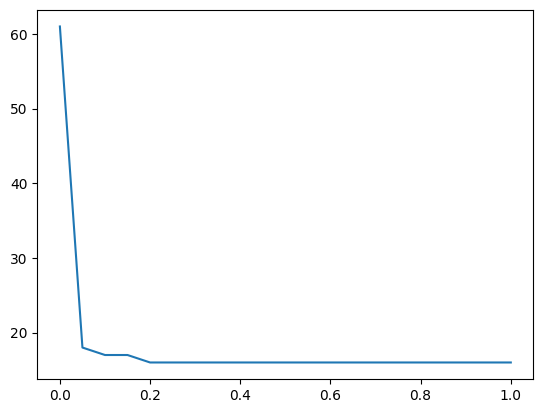

In [209]:
thresholds = np.arange(0.0, 1.05, 0.05)

# apply transform with each threshold
results = list()
for t in thresholds:
    # define the transform
    transform = VarianceThreshold(threshold=t)
    # transform the input data
    X_sel = transform.fit_transform(X_train_num)
    # determine the number of input features
    n_features = X_sel.shape[1]
    print(">Threshold=%.2f, Features=%d" % (t, n_features))
    # store the result
    results.append(n_features)
    # print(X_sel.dtype)

# plot the threshold vs the number of selected features
plt.plot(thresholds, results)
plt.show()

The line pot shows the relationship between the threshold and the number of features in the transformed dataset. I can see that with a small threshold of 0.10, 3 features are removed immediately.

First, we fit the estimator to data and call its get_support() method. It returns a boolean mask with True values for columns which are not dropped.

We can then use this mask to subset our DataFrame like so

In [210]:
_ = vt.fit(X_train_num)
mask = vt.get_support()

X_train_num = X_train_num.loc[:, mask]

# Let’s drop features with variances close to 0
vt = VarianceThreshold(threshold=1)

# Fit
_ = vt.fit(X_train_num)

# # Get the boolean mask
mask = vt.get_support()

X_train_LowVariance = X_train_num.loc[:, mask]

df_details("After dropping features with variances close to 0", X_train_LowVariance)

X_train_LowVariance.info()


| After dropping features with variances close to 0 | |
| --- | ---: |
| Number of observations | 29930 |
| Number of attributes | 16 |
| Size | 478880 |


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29930 entries, 0 to 29929
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   date                                   29930 non-null  float64
 1   new_cases                              29930 non-null  float64
 2   new_deaths                             29930 non-null  float64
 3   total_cases_per_million                29930 non-null  float64
 4   total_deaths_per_million               29930 non-null  float64
 5   new_vaccinations_smoothed              29930 non-null  float64
 6   new_vaccinations_smoothed_per_million  29930 non-null  float64
 7   stringency_index                       29930 non-null  float64
 8   population_density                     29930 non-null  float64
 9   median_age                             29930 non-null  float64
 10  gdp_per_capita                         29930 non-null  float64
 11  ca

# Generate Profiling Report
Data profiling is report is available in GitHub: CIND820_EDA_DataProfiling.html/CIND820_EDA_DataProfiling.ipynb

In [211]:
# Generate profiling report
# profile = ProfileReport(data, title="Profiling Report", html={'style':{'fullwith':True}})
# profile

# Modeling

In [212]:
train_dataset = X_train_LowVariance
test_dataset = df_test[X_train_LowVariance.columns]

train_dataset.columns
test_dataset.columns

Index(['date', 'new_cases', 'new_deaths', 'total_cases_per_million',
       'total_deaths_per_million', 'new_vaccinations_smoothed',
       'new_vaccinations_smoothed_per_million', 'stringency_index',
       'population_density', 'median_age', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence',
       'hospital_beds_per_thousand', 'life_expectancy', 'total_cases'],
      dtype='object')

Index(['date', 'new_cases', 'new_deaths', 'total_cases_per_million',
       'total_deaths_per_million', 'new_vaccinations_smoothed',
       'new_vaccinations_smoothed_per_million', 'stringency_index',
       'population_density', 'median_age', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence',
       'hospital_beds_per_thousand', 'life_expectancy', 'total_cases'],
      dtype='object')